In [156]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp

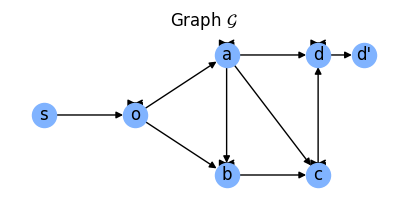

In [157]:
# constants
Lambda = 100
wd = 2

# build matrices and Graph
transition = np.array([
    [0, Lambda,   0,   0,   0,   0], # add source node to O with rate Lambda
    [0,      0, 3/4, 3/4,   0,   0],
    [0,      0,   0, 1/4, 1/4, 2/4],
    [0,      0,   0,   0,   1,   0],
    [0,      0,   0,   0,   0,   1],
    [0,      0,   0,   0,   0,   0]])

G = nx.DiGraph()
nodes_position_to_name = ['s','o', 'a', 'b', 'c', 'd']
for i, row in enumerate(transition):
  for j, element in enumerate(row):
    if element != 0:
      G.add_edge(nodes_position_to_name[i],nodes_position_to_name[j], transition=element)

for i, node in enumerate(G.nodes()):
  G.nodes[node]["omega"]=sum(transition[i,:])
  G.nodes[node]["n_par"]=0

G.nodes['d']['omega'] = wd
# a particle is always ready to enter the system with rate Lambda
G.nodes['s']['n_par'] = 1

system_freq = max([G.nodes[node]["omega"] for node in list(G.nodes())[1:]])
P_bar = np.array([[lambda_ij/system_freq for lambda_ij in node_i] for node_i in transition[1:,1:]])
for i in range(P_bar.shape[0]): P_bar[i,i] = 1 - sum(P_bar[i])
for i, row in enumerate(P_bar):
  for j, element in enumerate(row):
    if element != 0:
      G.add_edge(nodes_position_to_name[i+1],nodes_position_to_name[j+1], probability_bar=element)

# plot G
GG = G.copy()
GG.add_edge('d', "d'")
nodes_pos = {'o':(0,0),'a': (10,10), 'b': (10,-10), 'c': (20,-10),'d': (20,10), 's': (-10,0), "d'": (25,10)}
fig, ax = plt.subplots(figsize=(5,2))
self_loops = []
for e in GG.edges():
  if e[0] == e[1]: self_loops.append(e)
nx.draw(GG, with_labels=True, pos=nodes_pos, node_color="#80B3FF")
nx.draw_networkx_edges(GG, nodes_pos, edgelist=self_loops, arrowstyle="<|-", style="dashed")
plt.title("Graph $\mathcal{G}$")
fig.savefig('ex3_G.svg', format='svg', dpi=1200)
plt.show()


In [158]:
#transition con s e d'
transition = np.array([
    [0, Lambda,   0,   0,   0,   0,  0],
    [0,      0, 3/4, 3/4,   0,   0, 0],
    [0,      0,   0, 1/4, 1/4, 2/4, 0],
    [0,      0,   0,   0,   1,   0, 0],
    [0,      0,   0,   0,   0,   1, 0],
    [0,      0,   0,   0,   0,   0, 2],
    [0,      0,   0,   0,   0,  0,  0]])

omega = transition @ np.ones(7)
invOmega = np.zeros(7)
for i in range(7):
  if(omega[i] != 0):
    invOmega[i] = 1/omega[i]
P =  np.diag(invOmega) @ transition
Q = P[:6,:6]
IQinv = np.linalg.inv(np.eye(6) - Q)


In [159]:
def ProportionalRandomWalk(G, max_time=60, system_frequency=2, input_rate=100):
  nodes_info = {node:{"time":[0], "n":[int(G.nodes[node]['n_par'])], "1/tao":[0]} for node in G.nodes()}
  system_info = {"time": [0], "num_particles_in_system":[0]}
  time = 0
  num_particles_in_system = 0
  while time < max_time:
    # simulate poisson clock
    u = np.random.uniform(0,1,1)
    global_freq = max(input_rate, system_frequency*num_particles_in_system)
    time += -1*np.log(u)/(global_freq)

    # select node to move from given internal clock and number of particles in it
    node_probabilities = np.array([n_attr["n_par"]*n_attr["omega"] for node, n_attr in G.nodes().items()])
    tao = IQinv @ (np.ones(len(node_probabilities))/node_probabilities)

    node_probabilities /= sum(node_probabilities) # normalize to sum 1
    select_node = np.random.choice(G.nodes(), 1, p=node_probabilities)[0]

    # add particle to the system
    if select_node == 's':
      num_particles_in_system += 1
      G.nodes['o']['n_par'] += 1
      system_info["num_particles_in_system"].append(num_particles_in_system)
      system_info["time"].append(time[0])

    # remove particle from the system
    elif select_node == 'd':
      num_particles_in_system -= 1
      G.nodes['d']['n_par'] -= 1
      system_info["num_particles_in_system"].append(num_particles_in_system)
      system_info["time"].append(time[0])

    else:
      # select next node for a particle to move to
      step_probabilities = [G[select_node][a]["probability_bar"] for a in G.adj[select_node]]
      next_node = np.random.choice(G.adj[select_node], 1, p=step_probabilities)[0]
      # move particle
      G.nodes[select_node]['n_par'] -= 1
      G.nodes[next_node]['n_par'] += 1


    # save info in time
    for i, node in enumerate(G.nodes()):
      nodes_info[node]["time"].append(time[0])
      nodes_info[node]["n"].append(int(G.nodes[node]["n_par"]))
      nodes_info[node]["1/tao"].append(1/tao[i])

  return system_info, nodes_info

In [160]:
# reset
for i, node in enumerate(G.nodes()): G.nodes[node]["n_par"]=0
G.nodes['s']['n_par'] = 1

sys_info, node_info = ProportionalRandomWalk(G, system_frequency=system_freq, input_rate=Lambda, max_time=60)

<ipython-input-159-c6b2df4dc70d>:14: RuntimeWarning: divide by zero encountered in divide
  tao = IQinv @ (np.ones(len(node_probabilities))/node_probabilities)
<ipython-input-159-c6b2df4dc70d>:14: RuntimeWarning: invalid value encountered in matmul
  tao = IQinv @ (np.ones(len(node_probabilities))/node_probabilities)


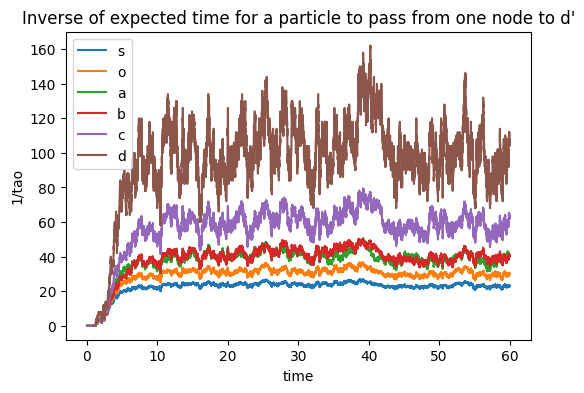

In [ ]:
# plot results
fig, ax = plt.subplots(figsize=(6,4))
for node in G.nodes():
  plt.plot(node_info[node]["time"],node_info[node]["1/tao"], label=node, linewidth=1.5)
plt.legend()
plt.title("Inverse of expected time for a particle to pass from one node to d'")
plt.xlabel("time")
plt.ylabel("1/tao")
# fig.savefig('ex3_proportional_tao.svg', format='svg', dpi=1200)
plt.show()

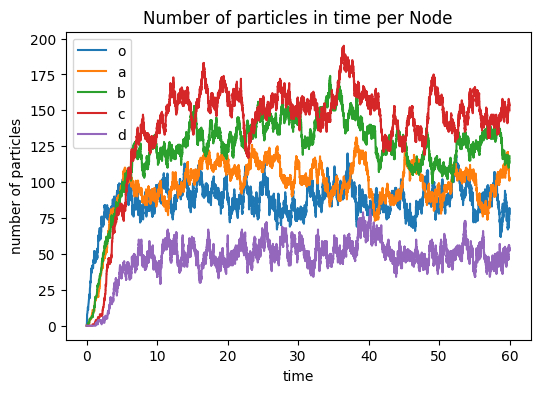

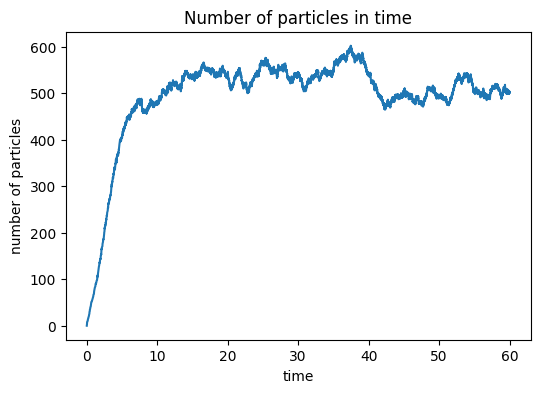

In [ ]:
# plot results
fig, ax = plt.subplots(figsize=(6,4))
for node in G.nodes():
  if node != 's': plt.plot(node_info[node]["time"],node_info[node]["n"], label=node, linewidth=1.5)
plt.legend()
plt.title("Number of particles in time per Node")
plt.xlabel("time")
plt.ylabel("number of particles")
# fig.savefig('ex3_proportional_particles_in_time_per_node.svg', format='svg', dpi=1200)
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
plt.plot(sys_info["time"], sys_info["num_particles_in_system"])
plt.title("Number of particles in time")
plt.xlabel("time")
plt.ylabel("number of particles")
# fig.savefig('ex3_proportional_particles_in_time_total.svg', format='svg', dpi=1200)

plt.show()

---------------------------------------------------

FIXED RANDOM WALK

In [176]:
# constants
Lambda = 1
wd = 2

# build matrices and Graph
transition = np.array([
    [0, Lambda,   0,   0,   0,   0], # add source node to O with rate Lambda
    [0,      0, 3/4, 3/4,   0,   0],
    [0,      0,   0, 1/4, 1/4, 2/4],
    [0,      0,   0,   0,   1,   0],
    [0,      0,   0,   0,   0,   1],
    [0,      0,   0,   0,   0,   0]])

G = nx.DiGraph()
nodes_position_to_name = ['s','o', 'a', 'b', 'c', 'd']
for i, row in enumerate(transition):
  for j, element in enumerate(row):
    if element != 0:
      G.add_edge(nodes_position_to_name[i],nodes_position_to_name[j], transition=element)

for i, node in enumerate(G.nodes()):
  G.nodes[node]["omega"]=sum(transition[i,:])
  G.nodes[node]["n_par"]=0

G.nodes['d']['omega'] = wd
# a particle is always ready to enter the system with rate Lambda
G.nodes['s']['n_par'] = 1

system_freq = max([G.nodes[node]["omega"] for node in list(G.nodes())[1:]])
P_bar = np.array([[lambda_ij/system_freq for lambda_ij in node_i] for node_i in transition[1:,1:]])
for i in range(P_bar.shape[0]): P_bar[i,i] = 1 - sum(P_bar[i])
for i, row in enumerate(P_bar):
  for j, element in enumerate(row):
    if element != 0:
      G.add_edge(nodes_position_to_name[i+1],nodes_position_to_name[j+1], probability_bar=element)

In [170]:
def FixedRandomWalk(G, max_time=60, system_frequency=2, input_rate=1):
  nodes_info = {node:{"time":[0], "n":[int(G.nodes[node]['n_par'])]} for node in G.nodes()}
  system_info = {"time": [0], "num_particles_in_system":[0]}
  time = 0
  num_particles_in_system = 0
  while time < max_time:
    # simulate poisson clock
    u = np.random.uniform(0,1,1)
    global_freq = max(input_rate, system_frequency) # removed *num_particles_in_system
    time += -1*np.log(u)/(global_freq)

    # select node to move from given internal clock and number of particles in it
    # consider only clock of nodes with particles, i.e. *(n_attr["n_par"] != 0), boolean expression
    node_probabilities = np.array([n_attr["omega"]*(n_attr["n_par"] != 0) for node, n_attr in G.nodes().items()])
    node_probabilities /= sum(node_probabilities) # normalize to sum 1
    select_node = np.random.choice(G.nodes(), 1, p=node_probabilities)[0]

    # add particle to the system
    if select_node == 's':
      num_particles_in_system += 1
      G.nodes['o']['n_par'] += 1
      system_info["num_particles_in_system"].append(num_particles_in_system)
      system_info["time"].append(time[0])

    # remove particle from the system
    elif select_node == 'd':
      num_particles_in_system -= 1
      G.nodes['d']['n_par'] -= 1
      system_info["num_particles_in_system"].append(num_particles_in_system)
      system_info["time"].append(time[0])

    else:
      # select next node for a particle to move to
      step_probabilities = [G[select_node][a]["probability_bar"] for a in G.adj[select_node]]
      next_node = np.random.choice(G.adj[select_node], 1, p=step_probabilities)[0]
      # move particle
      G.nodes[select_node]['n_par'] -= 1
      G.nodes[next_node]['n_par'] += 1

    # save info in time
    for node in G.nodes():
      nodes_info[node]["time"].append(time[0])
      nodes_info[node]["n"].append(int(G.nodes[node]["n_par"]))

  return system_info, nodes_info

In [177]:
# reset
for i, node in enumerate(G.nodes()): G.nodes[node]["n_par"]=0
G.nodes['s']['n_par'] = 1

sys_info, node_info = FixedRandomWalk(G, system_frequency=system_freq, input_rate=Lambda, max_time=60)

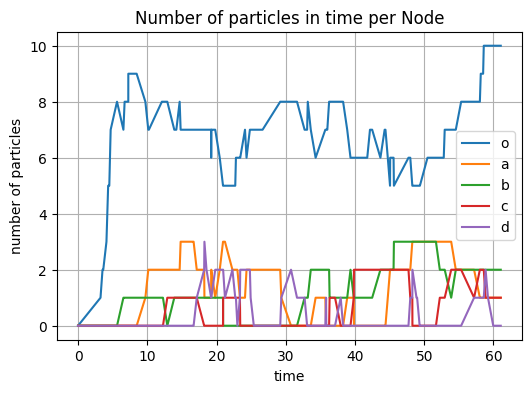

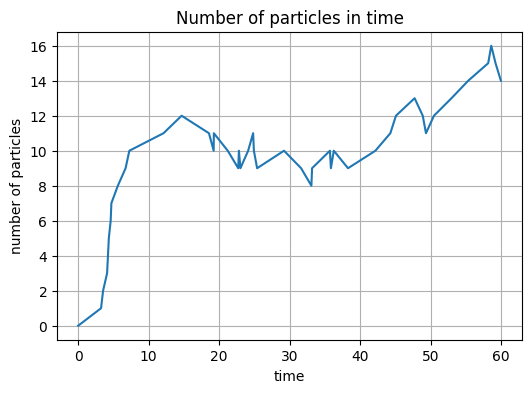

In [178]:
# plot results
fig, ax = plt.subplots(figsize=(6,4))
for node in G.nodes():
  if node != 's': plt.plot(node_info[node]["time"],node_info[node]["n"], label=node, linewidth=1.5)
plt.legend()
plt.title("Number of particles in time per Node")
plt.xlabel("time")
plt.ylabel("number of particles")
plt.grid()
fig.savefig('ex3_fixed_node_lambda_time.svg', format='svg', dpi=1200)
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
plt.plot(sys_info["time"], sys_info["num_particles_in_system"])
plt.title("Number of particles in time")
plt.xlabel("time")
plt.ylabel("number of particles")
plt.grid()
fig.savefig('ex3_fixed_total_lambda_time.svg', format='svg', dpi=1200)

plt.show()

In [173]:
# find max Lambda
T = np.zeros((6,6))
T[:5,:5] = np.array(transition[1:,1:])
T[4,5] = wd
omega = T @ np.ones(6)
P = np.array([[lambda_ij/sum(node_i) if sum(node_i)!= 0 else 0 for lambda_ij in node_i] for node_i in T])
Q = P[:5,:5]
print("Q =\n", Q)
IQinv = np.linalg.inv(np.eye(5) - Q)
tao = IQinv @ (1/omega[:5])
print("Tao =", tao)
print(f"max Lambda = {1/tao[0]}")

Q =
 [[0.   0.5  0.5  0.   0.  ]
 [0.   0.   0.25 0.25 0.5 ]
 [0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   1.  ]
 [0.   0.   0.   0.   0.  ]]
Tao = [3.04166667 2.25       2.5        1.5        0.5       ]
max Lambda = 0.32876712328767127


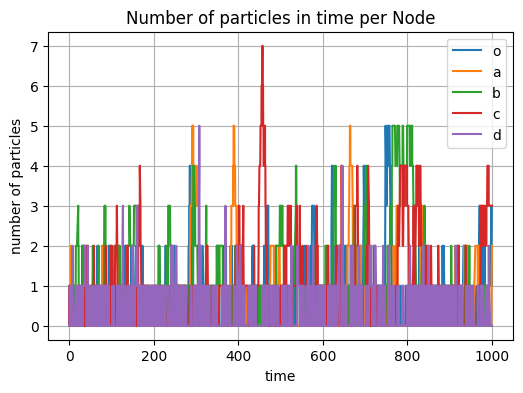

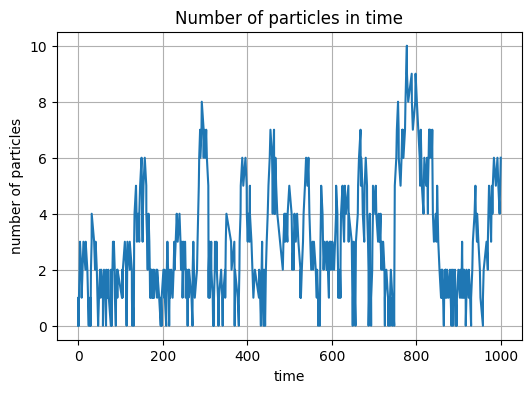

In [174]:
# test with Lambda = 0.3

# constants
Lambda = 0.3
wd = 2

# build matrices and Graph
transition = np.array([
    [0, Lambda,   0,   0,   0,   0], # add source node to O with rate Lambda
    [0,      0, 3/4, 3/4,   0,   0],
    [0,      0,   0, 1/4, 1/4, 2/4],
    [0,      0,   0,   0,   1,   0],
    [0,      0,   0,   0,   0,   1],
    [0,      0,   0,   0,   0,   0]])

G = nx.DiGraph()
nodes_position_to_name = ['s','o', 'a', 'b', 'c', 'd']
for i, row in enumerate(transition):
  for j, element in enumerate(row):
    if element != 0:
      G.add_edge(nodes_position_to_name[i],nodes_position_to_name[j], transition=element)

for i, node in enumerate(G.nodes()):
  G.nodes[node]["omega"]=sum(transition[i,:])
  G.nodes[node]["n_par"]=0

G.nodes['d']['omega'] = wd

system_freq = max([G.nodes[node]["omega"] for node in list(G.nodes())[1:]])
P_bar = np.array([[lambda_ij/system_freq for lambda_ij in node_i] for node_i in transition[1:,1:]])
for i in range(P_bar.shape[0]): P_bar[i,i] = 1 - sum(P_bar[i])
for i, row in enumerate(P_bar):
  for j, element in enumerate(row):
    if element != 0:
      G.add_edge(nodes_position_to_name[i+1],nodes_position_to_name[j+1], probability_bar=element)

for i, node in enumerate(G.nodes()): G.nodes[node]["n_par"]=0
G.nodes['s']['n_par'] = 1

sys_info, node_info = FixedRandomWalk(G, system_frequency=system_freq, input_rate=Lambda, max_time=1000)

# plot results
fig, ax = plt.subplots(figsize=(6,4))
for node in G.nodes():
  if node != 's': plt.plot(node_info[node]["time"],node_info[node]["n"], label=node, linewidth=1.5)
plt.legend()
plt.title("Number of particles in time per Node")
plt.xlabel("time")
plt.ylabel("number of particles")
plt.grid()
fig.savefig('ex3_fixed_node_lambda0.3.svg', format='svg', dpi=1200)
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
plt.plot(sys_info["time"], sys_info["num_particles_in_system"])
plt.title("Number of particles in time")
plt.xlabel("time")
plt.ylabel("number of particles")
plt.grid()
# fig.savefig('ex3_fixed_total_lambda0.3.svg', format='svg', dpi=1200)

plt.show()